# Vertex AI: Track parameters and metrics for locally trained models

## Overview

As a Data Scientist, you probably start running model experiments locally on your notebook. Depending on the framework you use, you would need to track parameters, training time series and evaluation metrics. In this way, you would be able to explain the modelling approach you would choose. 

Learn more about [Vertex AI Experiments](https://cloud.google.com/vertex-ai/docs/experiments/intro-vertex-ai-experiments).

### Objective

In this tutorial, you learn how to use Vertex AI Experiments to compare and evaluate model experiments.

This tutorial uses the following Google Cloud ML services and resources:

- Vertex AI Workbench
- Vertex AI Experiments

The steps performed include:

- log the model parameters
- log the loss and metrics on every epoch to TensorBoard
- log the evaluation metrics


### Dataset

In this notebook, we will train a simple distributed neural network (DNN) model to predict automobile's miles per gallon (MPG) based on automobile information in the [auto-mpg dataset](https://www.kaggle.com/devanshbesain/exploration-and-analysis-auto-mpg).


### Costs 

This tutorial uses billable components of Google Cloud:

* Vertex AI
* Vertex AI TensorBoard
* Cloud Storage

Learn about [Vertex AI
pricing](https://cloud.google.com/vertex-ai/pricing) and [Cloud Storage
pricing](https://cloud.google.com/storage/pricing), and use the [Pricing
Calculator](https://cloud.google.com/products/calculator/)
to generate a cost estimate based on your projected usage.

### Import libraries

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
from google.cloud import aiplatform as vertex_ai
from tensorflow.python.keras import Sequential, layers
from tensorflow.python.keras.utils import data_utils

### Define constants

In [32]:
PROJECT = 'qwiklabs-gcp-04-15a54282d7af'
LOCATION = 'us-central1'
EXPERIMENT_NAME = "test-experiment-0"

### Initialize Vertex AI SDK for Python

Initialize the Vertex AI SDK for Python for your project and corresponding bucket.

### Create TensorBoard instance using Vertex AI TensorBoard

You can upload your TensorBoard logs by first creating a Vertex AI TensorBoard instance.

**Notice** that if you did not activate yet, Vertex AI TensorBoard charges a monthly fee of $300 per unique active user. 

Learn more about [TensorBoard overview](https://cloud.google.com/vertex-ai/docs/experiments/tensorboard-overview).

In [34]:
vertex_ai_tb = vertex_ai.Tensorboard.create()

Creating Tensorboard


INFO:google.cloud.aiplatform.tensorboard.tensorboard_resource:Creating Tensorboard


Create Tensorboard backing LRO: projects/653299574369/locations/us-central1/tensorboards/7160415544263311360/operations/1374083664329048064


INFO:google.cloud.aiplatform.tensorboard.tensorboard_resource:Create Tensorboard backing LRO: projects/653299574369/locations/us-central1/tensorboards/7160415544263311360/operations/1374083664329048064


Tensorboard created. Resource name: projects/653299574369/locations/us-central1/tensorboards/7160415544263311360


INFO:google.cloud.aiplatform.tensorboard.tensorboard_resource:Tensorboard created. Resource name: projects/653299574369/locations/us-central1/tensorboards/7160415544263311360


To use this Tensorboard in another session:


INFO:google.cloud.aiplatform.tensorboard.tensorboard_resource:To use this Tensorboard in another session:


tb = aiplatform.Tensorboard('projects/653299574369/locations/us-central1/tensorboards/7160415544263311360')


INFO:google.cloud.aiplatform.tensorboard.tensorboard_resource:tb = aiplatform.Tensorboard('projects/653299574369/locations/us-central1/tensorboards/7160415544263311360')


In [36]:
vertex_ai.init(project=PROJECT, 
               location=LOCATION,
               experiment=EXPERIMENT_NAME,
               experiment_tensorboard=vertex_ai_tb)

## Training with Vertex AI Experiments

Vertex AI enables users to track the steps (for example, preprocessing, training) of an experiment run, and track inputs (for example, algorithm, parameters, datasets) and outputs (for example, models, checkpoints, metrics) of those steps. 

To better understanding how parameters and metrics are stored and organized, the following concepts are explained:

1. **Experiments** describe a context that groups your runs and the artifacts you create into a logical session. For example, in this notebook you create an Experiment and log data to that experiment.

1. **Run** represents a single path/avenue that you executed while performing an experiment. A run includes artifacts that you used as inputs or outputs, and parameters that you used in this execution. An Experiment can contain multiple runs. 

You can use the  Vertex AI SDK for Python to track metrics and parameters models trained locally for each experiment across several experiment runs. 

In the following example, you train a simple distributed neural network (DNN) model to predict automobile's miles per gallon (MPG) based on automobile information in the [auto-mpg dataset](https://www.kaggle.com/devanshbesain/exploration-and-analysis-auto-mpg).

In [37]:
# Helpers ----------------------------------------------------------------------

def read_data(uri):
    """
    Read data
    Args:
        uri: path to data
    Returns:
        pandas dataframe
    """
    dataset_path = data_utils.get_file("auto-mpg.data", uri)
    column_names = [
        "MPG",
        "Cylinders",
        "Displacement",
        "Horsepower",
        "Weight",
        "Acceleration",
        "Model Year",
        "Origin",
    ]
    raw_dataset = pd.read_csv(
        dataset_path,
        names=column_names,
        na_values="?",
        comment="\t",
        sep=" ",
        skipinitialspace=True,
    )
    dataset = raw_dataset.dropna()
    dataset["Origin"] = dataset["Origin"].map(
        lambda x: {1: "USA", 2: "Europe", 3: "Japan"}.get(x)
    )
    dataset = pd.get_dummies(dataset, prefix="", prefix_sep="")
    return dataset


def train_test_split(dataset, split_frac=0.8, random_state=0):
    """
    Split data into train and test
    Args:
        dataset: pandas dataframe
        split_frac: fraction of data to use for training
        random_state: random seed
    Returns:
        train and test dataframes
    """
    train_dataset = dataset.sample(frac=split_frac, random_state=random_state)
    test_dataset = dataset.drop(train_dataset.index)
    train_labels = train_dataset.pop("MPG")
    test_labels = test_dataset.pop("MPG")

    return train_dataset, test_dataset, train_labels, test_labels


def normalize_dataset(train_dataset, test_dataset):
    """
    Normalize data
    Args:
        train_dataset: pandas dataframe
        test_dataset: pandas dataframe

    Returns:

    """
    train_stats = train_dataset.describe()
    train_stats = train_stats.transpose()

    def norm(x):
        return (x - train_stats["mean"]) / train_stats["std"]

    normed_train_data = norm(train_dataset)
    normed_test_data = norm(test_dataset)

    return normed_train_data, normed_test_data


def build_model(num_units, dropout_rate):
    """
    Build model
    Args:
        num_units: number of units in hidden layer
        dropout_rate: dropout rate
    Returns:
        compiled model
    """
    model = Sequential(
        [
            layers.Dense(
                num_units,
                activation="relu",
                input_shape=[9],
            ),
            layers.Dropout(rate=dropout_rate),
            layers.Dense(num_units, activation="relu"),
            layers.Dense(1),
        ]
    )

    model.compile(loss="mse", optimizer="adam", metrics=["mae", "mse"])
    return model


def train(
    model,
    train_data,
    train_labels,
    validation_split=0.2,
    epochs=10,
):
    """
    Train model
    Args:
        train_data: pandas dataframe
        train_labels: pandas dataframe
        model: compiled model
        validation_split: fraction of data to use for validation
        epochs: number of epochs to train for
    Returns:
        history
    """
    history = model.fit(
        train_data, train_labels, epochs=epochs, validation_split=validation_split
    )

    return history

### Run experiment and evaluate experiment runs

You define several experiment configurations, run experiments and track them in Vertex AI Experiments

In [38]:
# Define experiment parameters
parameters = [
    {"num_units": 16, "dropout_rate": 0.1, "epochs": 3},
    {"num_units": 16, "dropout_rate": 0.1, "epochs": 10},
    {"num_units": 16, "dropout_rate": 0.2, "epochs": 10},
    {"num_units": 32, "dropout_rate": 0.1, "epochs": 10},
    {"num_units": 32, "dropout_rate": 0.2, "epochs": 10},
]

# Read data
dataset = read_data(
    "http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data"
)

# Split data
train_dataset, test_dataset, train_labels, test_labels = train_test_split(dataset)

# Normalize data
normed_train_data, normed_test_data = normalize_dataset(train_dataset, test_dataset)

# Run experiments
for i, params in enumerate(parameters):

    # Initialize Vertex AI Experiment run
    vertex_ai.start_run(run=f"auto-mpg-local-run-{i}")

    # Log training parameters
    vertex_ai.log_params(params)

    # Build model
    model = build_model(
        num_units=params["num_units"], dropout_rate=params["dropout_rate"]
    )

    # Train model
    history = train(
        model,
        normed_train_data,
        train_labels,
        epochs=params["epochs"],
    )

    # Log additional parameters
    vertex_ai.log_params(history.params)

    # Log metrics per epochs (Time Series Metrics - for Tensorboard)
    for idx in range(0, history.params["epochs"]):
        vertex_ai.log_time_series_metrics(
            {
                "train_mae": history.history["mae"][idx],
                "train_mse": history.history["mse"][idx],
            }
        )

    # Log final metrics
    loss, mae, mse = model.evaluate(normed_test_data, test_labels, verbose=2)
    vertex_ai.log_metrics({"eval_loss": loss, "eval_mae": mae, "eval_mse": mse})

    vertex_ai.end_run()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Associating projects/653299574369/locations/us-central1/metadataStores/default/contexts/test-experiment-0-auto-mpg-local-run-0 to Experiment: test-experiment-0


INFO:google.cloud.aiplatform.metadata.experiment_resources:Associating projects/653299574369/locations/us-central1/metadataStores/default/contexts/test-experiment-0-auto-mpg-local-run-0 to Experiment: test-experiment-0


Epoch 1/3
8/8 [==============================] - 1s 23ms/step - loss: 575.0167 - mae: 22.7529 - mse: 575.0167 - val_loss: 590.2210 - val_mae: 23.0788 - val_mse: 590.2210
Epoch 2/3
8/8 [==============================] - 0s 5ms/step - loss: 558.9492 - mae: 22.4379 - mse: 558.9492 - val_loss: 574.3516 - val_mae: 22.7535 - val_mse: 574.3516
Epoch 3/3
8/8 [==============================] - 0s 5ms/step - loss: 544.7881 - mae: 22.1386 - mse: 544.7881 - val_loss: 557.6143 - val_mae: 22.4092 - val_mse: 557.6143
3/3 - 0s - loss: 572.2098 - mae: 22.6452 - mse: 572.2098
Associating projects/653299574369/locations/us-central1/metadataStores/default/contexts/test-experiment-0-auto-mpg-local-run-1 to Experiment: test-experiment-0


INFO:google.cloud.aiplatform.metadata.experiment_resources:Associating projects/653299574369/locations/us-central1/metadataStores/default/contexts/test-experiment-0-auto-mpg-local-run-1 to Experiment: test-experiment-0


Epoch 1/10
8/8 [==============================] - 1s 23ms/step - loss: 572.7580 - mae: 22.5908 - mse: 572.7580 - val_loss: 592.9346 - val_mae: 22.9886 - val_mse: 592.9346
Epoch 2/10
8/8 [==============================] - 0s 5ms/step - loss: 566.4481 - mae: 22.4312 - mse: 566.4481 - val_loss: 585.4401 - val_mae: 22.8076 - val_mse: 585.4401
Epoch 3/10
8/8 [==============================] - 0s 5ms/step - loss: 559.5561 - mae: 22.2672 - mse: 559.5561 - val_loss: 577.5833 - val_mae: 22.6160 - val_mse: 577.5833
Epoch 4/10
8/8 [==============================] - 0s 5ms/step - loss: 551.5470 - mae: 22.0862 - mse: 551.5470 - val_loss: 569.2199 - val_mae: 22.4106 - val_mse: 569.2199
Epoch 5/10
8/8 [==============================] - 0s 5ms/step - loss: 543.9278 - mae: 21.8688 - mse: 543.9278 - val_loss: 560.0836 - val_mae: 22.1852 - val_mse: 560.0836
Epoch 6/10
8/8 [==============================] - 0s 5ms/step - loss: 535.5735 - mae: 21.6625 - mse: 535.5735 - val_loss: 549.8375 - val_mae: 21.9305

INFO:google.cloud.aiplatform.metadata.experiment_resources:Associating projects/653299574369/locations/us-central1/metadataStores/default/contexts/test-experiment-0-auto-mpg-local-run-2 to Experiment: test-experiment-0


Epoch 1/10
8/8 [==============================] - 1s 23ms/step - loss: 568.4247 - mae: 22.6158 - mse: 568.4247 - val_loss: 595.4845 - val_mae: 23.1727 - val_mse: 595.4845
Epoch 2/10
8/8 [==============================] - 0s 5ms/step - loss: 561.7313 - mae: 22.4920 - mse: 561.7313 - val_loss: 586.5656 - val_mae: 23.0043 - val_mse: 586.5656
Epoch 3/10
8/8 [==============================] - 0s 6ms/step - loss: 551.2204 - mae: 22.2724 - mse: 551.2204 - val_loss: 576.9360 - val_mae: 22.8212 - val_mse: 576.9360
Epoch 4/10
8/8 [==============================] - 0s 4ms/step - loss: 543.4050 - mae: 22.1215 - mse: 543.4050 - val_loss: 566.3925 - val_mae: 22.6185 - val_mse: 566.3925
Epoch 5/10
8/8 [==============================] - 0s 5ms/step - loss: 533.9868 - mae: 21.9281 - mse: 533.9868 - val_loss: 554.2427 - val_mae: 22.3840 - val_mse: 554.2427
Epoch 6/10
8/8 [==============================] - 0s 5ms/step - loss: 522.8176 - mae: 21.7119 - mse: 522.8176 - val_loss: 540.5671 - val_mae: 22.1178

INFO:google.cloud.aiplatform.metadata.experiment_resources:Associating projects/653299574369/locations/us-central1/metadataStores/default/contexts/test-experiment-0-auto-mpg-local-run-3 to Experiment: test-experiment-0


Epoch 1/10
8/8 [==============================] - 1s 37ms/step - loss: 600.3329 - mae: 23.2526 - mse: 600.3329 - val_loss: 621.3459 - val_mae: 23.6644 - val_mse: 621.3459
Epoch 2/10
8/8 [==============================] - 0s 7ms/step - loss: 590.1422 - mae: 23.0235 - mse: 590.1422 - val_loss: 610.0425 - val_mae: 23.4100 - val_mse: 610.0425
Epoch 3/10
8/8 [==============================] - 0s 7ms/step - loss: 579.0546 - mae: 22.7733 - mse: 579.0546 - val_loss: 597.5388 - val_mae: 23.1228 - val_mse: 597.5388
Epoch 4/10
8/8 [==============================] - 0s 7ms/step - loss: 567.0671 - mae: 22.4975 - mse: 567.0671 - val_loss: 583.1577 - val_mae: 22.7883 - val_mse: 583.1577
Epoch 5/10
8/8 [==============================] - 0s 8ms/step - loss: 552.1586 - mae: 22.1384 - mse: 552.1586 - val_loss: 566.1884 - val_mae: 22.3921 - val_mse: 566.1884
Epoch 6/10
8/8 [==============================] - 0s 8ms/step - loss: 535.7509 - mae: 21.7394 - mse: 535.7509 - val_loss: 546.0631 - val_mae: 21.9174

INFO:google.cloud.aiplatform.metadata.experiment_resources:Associating projects/653299574369/locations/us-central1/metadataStores/default/contexts/test-experiment-0-auto-mpg-local-run-4 to Experiment: test-experiment-0


Epoch 1/10
8/8 [==============================] - 1s 22ms/step - loss: 604.4916 - mae: 23.3337 - mse: 604.4916 - val_loss: 624.5139 - val_mae: 23.7275 - val_mse: 624.5139
Epoch 2/10
8/8 [==============================] - 0s 5ms/step - loss: 588.2787 - mae: 22.9893 - mse: 588.2787 - val_loss: 608.2618 - val_mae: 23.3680 - val_mse: 608.2618
Epoch 3/10
8/8 [==============================] - 0s 5ms/step - loss: 574.0432 - mae: 22.6656 - mse: 574.0432 - val_loss: 590.8344 - val_mae: 22.9882 - val_mse: 590.8344
Epoch 4/10
8/8 [==============================] - 0s 7ms/step - loss: 554.9203 - mae: 22.2469 - mse: 554.9203 - val_loss: 570.8441 - val_mae: 22.5536 - val_mse: 570.8441
Epoch 5/10
8/8 [==============================] - 0s 5ms/step - loss: 536.3688 - mae: 21.8189 - mse: 536.3688 - val_loss: 547.6412 - val_mae: 22.0460 - val_mse: 547.6412
Epoch 6/10
8/8 [==============================] - 0s 5ms/step - loss: 513.6316 - mae: 21.3151 - mse: 513.6316 - val_loss: 520.4928 - val_mae: 21.4412

### Extract parameters and metrics into a dataframe for analysis

We can also extract all parameters and metrics associated with any Experiment into a dataframe for further analysis.

In [39]:
experiment_df = vertex_ai.get_experiment_df()
experiment_df.T

,0,1,2,3,4
experiment_name,test-experiment-0,test-experiment-0,test-experiment-0,test-experiment-0,test-experiment-0
run_name,auto-mpg-local-run-4,auto-mpg-local-run-3,auto-mpg-local-run-2,auto-mpg-local-run-1,auto-mpg-local-run-0
run_type,system.ExperimentRun,system.ExperimentRun,system.ExperimentRun,system.ExperimentRun,system.ExperimentRun
state,COMPLETE,COMPLETE,COMPLETE,COMPLETE,COMPLETE
param.dropout_rate,0.2,0.1,0.2,0.1,0.1
param.verbose,1.0,1.0,1.0,1.0,1.0
param.num_units,32.0,32.0,16.0,16.0,16.0
param.steps,8.0,8.0,8.0,8.0,8.0
param.epochs,10.0,10.0,10.0,10.0,3.0
metric.eval_loss,377.681427,446.343842,476.842651,515.855896,572.209839


### Visualizing an experiment's parameters and metrics

You use parallel coordinates plotting to visualize experiment's parameters and metrics

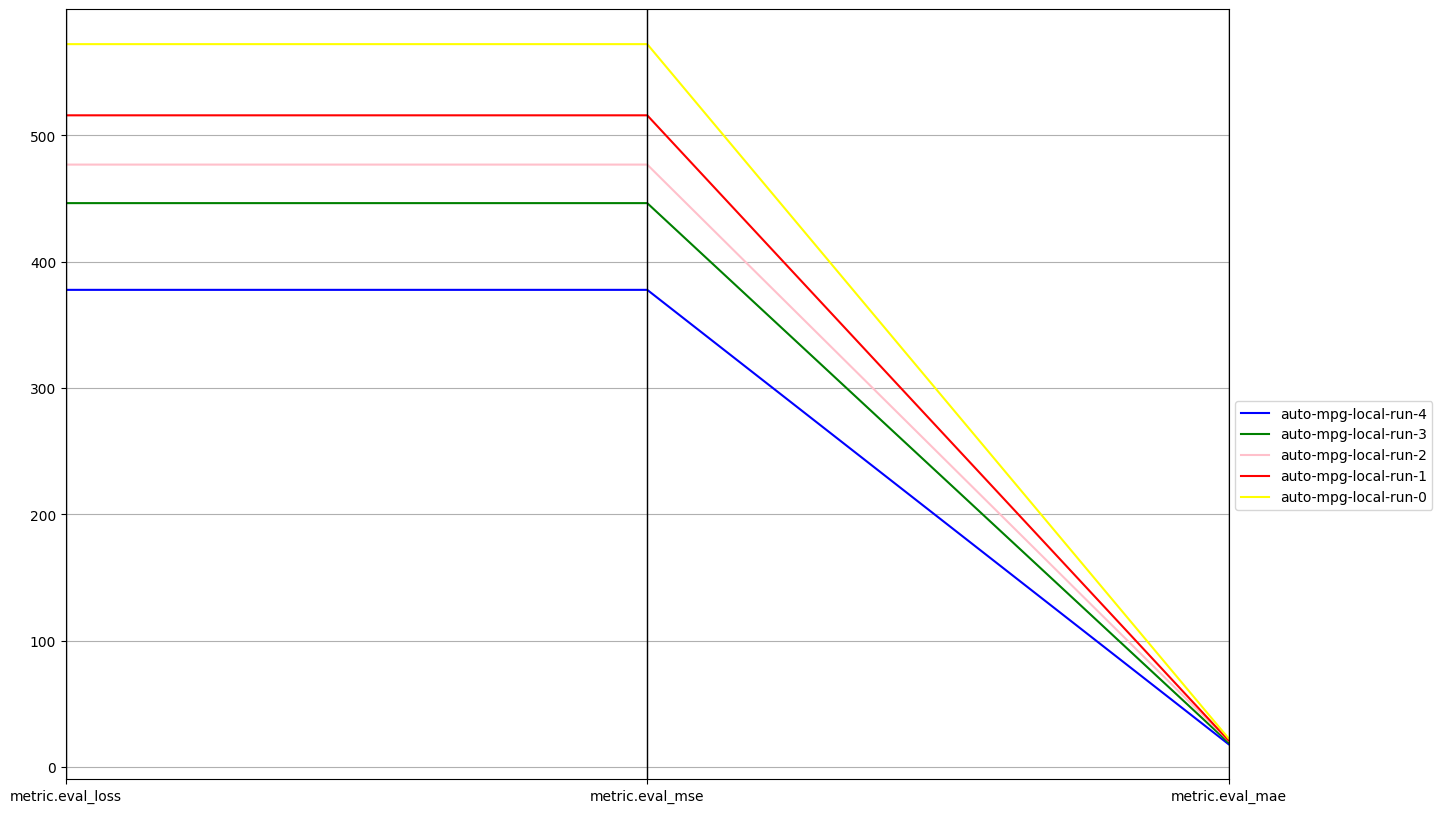

In [40]:
plt.rcParams["figure.figsize"] = [15, 10]

ax = pd.plotting.parallel_coordinates(
    experiment_df.reset_index(level=0),
    "run_name",
    cols=[
        # "param.num_units",
        # "param.dropout_rate",
        # "param.epochs",
        "metric.eval_loss",
        "metric.eval_mse",
        "metric.eval_mae",
    ],
    color=["blue", "green", "pink", "red", "yellow"],
)
# ax.set_yscale("symlog")
ax.legend(bbox_to_anchor=(1.0, 0.5))

## Cleaning up

You can delete the individual resources you created in this tutorial.

In [41]:
# # Delete experiment
# exp = vertex_ai.Experiment(EXPERIMENT_NAME)
# exp.delete(delete_backing_tensorboard_runs=True)

# # Delete Tensorboard
# vertex_ai_tb.delete()

# # Delete Cloud Storage objects that were created
# delete_bucket = False

# if delete_bucket or os.getenv("IS_TESTING"):
#     ! gsutil rm -rf {BUCKET_URI}